<a href="https://colab.research.google.com/github/Dzy00/CHL5230-Final-Project/blob/main/CHL5230_final_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CHL5230 Final Project Neural Networks

In [37]:
#  CHL5230 final project C CHANGE dataset neural network

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch as t
from torch.nn.functional import sigmoid, relu, tanh
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
# importing PyTorch modules for building neural networks
from torch.nn import Tanh, Linear, Sequential, Sigmoid, Dropout

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.over_sampling import SMOTE

# warnings.filterwarnings('ignore')

# read the cleaned dataset, so we don't have to rerun the above exploratory and cleaned code
CHANGE_selected = pd.read_csv('CHANGE_selected.csv')


# Define the column that will be used as the target for modeling or analysis
target_column = 'MacroVasc'

# List of columns that contain categorical data
categorical_columns = ['Sex','Any_AntiHTN','HeartFailure_Hx','AtrialFibrillation_Hx',
                       'Smoking_Status','Hypertension_Hx','diabetes']

# List of columns that contain numerical data (excluding categorical columns and the target column)
numerical_columns = [c for c in CHANGE_selected.columns if c not in categorical_columns and c != target_column]


########################################################## neural network
##### prepare data
# Randomly sample 80% of the data for training
train_data = CHANGE_selected.sample(frac = .8, random_state=10)

# Use the remaining 20% for testing
test_data = CHANGE_selected.drop(train_data.index)

# Check the mean of the 'DEATH_EVENT' column in both training and testing data
train_data['MacroVasc'].mean()
test_data['MacroVasc'].mean()

# Data Preparation
# Extract the 'MacroVasc' column as the target variable for training and testing
Y_train = train_data['MacroVasc'].to_numpy()
Y_test = test_data['MacroVasc'].to_numpy()

# Extract the features (excluding 'MacroVasc') for training and testing
X_train = train_data.drop('MacroVasc', axis=1)
X_test = test_data.drop('MacroVasc', axis=1)


##### imputation
# imputate numerical columns with median
num_transformer = SimpleImputer(strategy = 'median')

# impute categorical columns with the most frequent value and encode
cat_transformer = SimpleImputer(strategy = 'most_frequent')

# initialize a column transformer that handels imputation
ct = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_columns),
        ('cat', cat_transformer, categorical_columns)
        ],
    remainder='passthrough')

# Apply the ColumnTransformer to the data
ct.fit(X_train)
ct.fit(X_test)

# transform the data and convert to DataFrame with the new column names
X_train = pd.DataFrame(ct.transform(X_train), columns=ct.get_feature_names_out())
X_test = pd.DataFrame(ct.transform(X_test), columns=ct.get_feature_names_out())

# Standardize the features to have zero mean and unit variance
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# undersample
undersample = RandomUnderSampler(sampling_strategy=0.5)
X_resampled, Y_resampled = undersample.fit_resample(X_train, Y_train)
upsample = SMOTE(sampling_strategy=1)
X_resampled, Y_resampled = upsample.fit_resample(X_resampled, Y_resampled)




# Implementing the Forward Pass of a Neural Network in PyTorch

In [ ]:
##### Initializing Neural Network Parameters in PyTorch
# Define the number of neurons in the first and second hidden layers
hidden_units_layer_1 = 5
hidden_units_layer_2 = 5

# FIRST LAYER: Define weights and biases for the first layer
W1 = t.randn((16, hidden_units_layer_1), requires_grad=True)
B1 = t.zeros((1, hidden_units_layer_1), requires_grad=True)

# SECOND LAYER: Define weights and biases for the second layer
W2 = t.randn((hidden_units_layer_1, hidden_units_layer_2), requires_grad=True)
B2 = t.zeros((1, hidden_units_layer_2), requires_grad=True)

# THIRD LAYER: Define weights and biases for the output layer
W3 = t.randn((hidden_units_layer_2, 1), requires_grad=True)
B3 = t.zeros((1, 1), requires_grad=True)


# matrix multiplication: @
##### Define the forward pass of the neural network
def forward(input):
    # First hidden layer with tanh activation
    out = tanh(input @ W1 + B1)

    # Second hidden layer with tanh activation
    out = tanh(out @ W2 + B2)

    # Output layer with sigmoid activation (since it's a binary classification problem)
    out = sigmoid(out @ W3 + B3)
    return out

# Convert the training data to PyTorch tensors
X = t.Tensor(X_resampled).type(t.float32)
Y = t.Tensor(Y_resampled).type(t.float32)

# Create a dataset from tensors to be used with DataLoader
train_dataset = TensorDataset(X, Y)

# Define training hyperparameters
epochs = 2000
learning_rate = 0.01
batch_size = 32

# DataLoader provides batches of data for training
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the optimizer (Adam) and include all weights and biases
optimizer = Adam([W1, B1, W2, B2, W3, B3], lr=learning_rate)

# Define the loss function (Binary Cross-Entropy Loss)
loss_fn = t.nn.BCELoss()


##### training loop
train_loss_list = []

# Train the model for a specified number of epochs
for epoch in range(epochs):
    # Reduce the learning rate every 500 epochs
    if epoch % 500 == 0:
        learning_rate *= .9

    per_epoch_loss_list = []

    # Iterate over all batches of data
    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = forward(X)

        # Compute the loss
        loss = loss_fn(probs.view(-1), Y)

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record the loss for this batch
        per_epoch_loss_list.append(loss.item())

    # Record the average loss for this epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

# Plot the training loss over epochs
plt.plot([i for i in range(len(train_loss_list))], train_loss_list)
plt.xlabel('epochs')
plt.ylabel('loss')

# Evaluate Model Performance on Validation Data
# Disable gradient calculations for evaluation using t.no_grad()
with t.no_grad():
    # Prepare the validation data
    X = t.Tensor(X_test).type(t.float32) # Convert validation features to a PyTorch tensor
    Y = t.Tensor(Y_test).type(t.float32) # Convert validation labels to a PyTorch tensor

    # Calculate predictions on the validation data
    probs = forward(X) # Pass validation data through the trained model
    loss = loss_fn(probs.view(-1), Y) # Compute the loss between predictions and actual labels

    # Print the validation loss
    print(loss.item())

    # Now, evaluate the model on the training data
    X = t.Tensor(X_train).type(t.float32) # Convert training features to a PyTorch tensor
    Y = t.Tensor(Y_train).type(t.float32) # Convert training labels to a PyTorch tensor

    # Calculate predictions on the training data
    probs = forward(X) # Pass training data through the trained model
    loss = loss_fn(probs.view(-1), Y) # Compute the loss between predictions and actual labels

    # Print the training loss
    print(loss.item())


KeyboardInterrupt: ignored

# prevent overfitting with L2 normalization

Epoch 0/100 ---> Train Accuracy: 0.8299007415771484, Validation Accuracy: 0.7883572578430176
Epoch 1/100 ---> Train Accuracy: 0.8295285105705261, Validation Accuracy: 0.8198632597923279
Epoch 2/100 ---> Train Accuracy: 0.8310173749923706, Validation Accuracy: 0.7911356687545776
Epoch 3/100 ---> Train Accuracy: 0.8291563391685486, Validation Accuracy: 0.8055455684661865
Epoch 4/100 ---> Train Accuracy: 0.831488847732544, Validation Accuracy: 0.7949700951576233
Epoch 5/100 ---> Train Accuracy: 0.8316128849983215, Validation Accuracy: 0.7886596918106079
Epoch 6/100 ---> Train Accuracy: 0.8298014998435974, Validation Accuracy: 0.8304233551025391
Epoch 7/100 ---> Train Accuracy: 0.8297767043113708, Validation Accuracy: 0.8209294676780701
Epoch 8/100 ---> Train Accuracy: 0.8295285105705261, Validation Accuracy: 0.7884290218353271
Epoch 9/100 ---> Train Accuracy: 0.8294292688369751, Validation Accuracy: 0.8182689547538757
Epoch 10/100 ---> Train Accuracy: 0.8309677243232727, Validation Accura

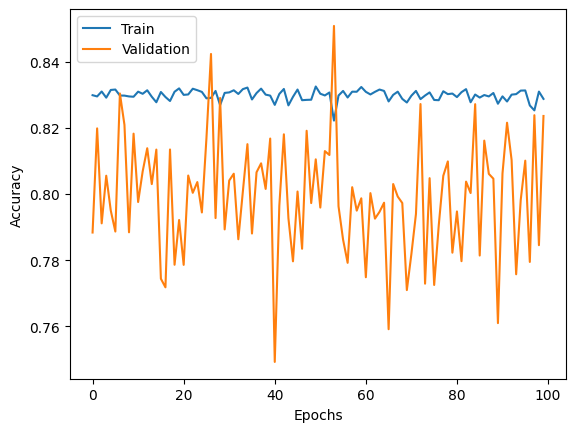


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.82      0.90    192558
         1.0       0.06      0.84      0.11      2516

    accuracy                           0.82    195074
   macro avg       0.53      0.83      0.51    195074
weighted avg       0.99      0.82      0.89    195074



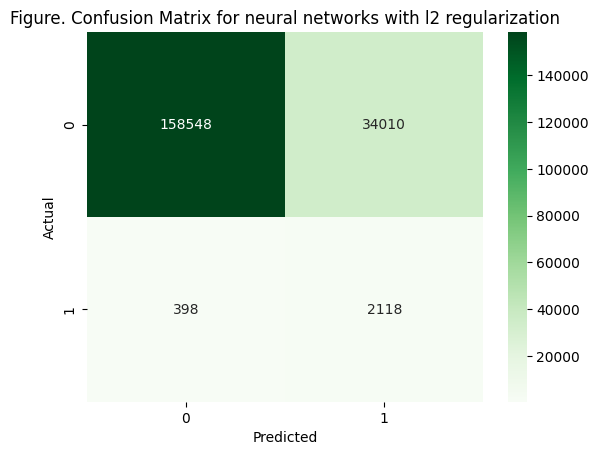

In [38]:
##### use l2 normalization to prevent overfitting
import torch as t
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Regularization
# Deep neural networks are prone to overfitting if there is not much data available during training.

# Define hyperparameters
number_of_input_features = 16
number_of_hidden_units = 5
epochs = 100
learning_rate = 0.01
batch_size = 32
landa = 0.01 # Regularization term (lambda)

# Prepare the data
X_train_tensor = t.Tensor(X_resampled).type(t.float32)
Y_train_tensor = t.Tensor(Y_resampled).type(t.float32)

X_test_tensor = t.Tensor(X_test).type(t.float32)
Y_test_tensor = t.Tensor(Y_test).type(t.float32)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the neural network model with regularization
model = nn.Sequential(
    nn.Linear(number_of_input_features, number_of_hidden_units), # Linear layer for matrix multiplication and bias addition
    nn.Tanh(), # Tanh activation function
    nn.Linear(number_of_hidden_units, 1), # Another linear layer
    nn.Sigmoid() # Sigmoid activation for probability output
)

# Define the optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Define the loss function with Binary Cross-Entropy Loss
loss_fn = nn.BCELoss()

# Lists to store training accuracy, validation accuracy, and training loss over epochs
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []

for epoch in range(epochs):
    if epoch % 500 == 0:
        learning_rate *= 0.9 # Learning rate scheduling

    per_epoch_loss_list = []

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model(X)

        # Adding regularization term for all parameters in the model
        l2_term = sum([(w ** 2).sum() for w in model.parameters()])

        # New loss is the old loss + regularization term
        loss = loss_fn(probs.view(-1), Y) + landa * l2_term

        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model on training and validation data
    with t.no_grad():
        # Set the model in eval mode; some layers use this for certain calculations during training
        model.eval()

        # Calculate accuracy on train data
        probs = model(X_train_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_tensor).type(t.float32).mean().item()

        # Calculate accuracy on validation data
        probs = model(X_test_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()

        # Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}, Validation Accuracy: {validation_accuracy}')

        # Set the model back to train mode
        model.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))


# Plot training and validation accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


# confusion matrix
conf_matrix = confusion_matrix(Y_test_tensor, prediction)
class_report = classification_report(Y_test_tensor, prediction)

print("\nClassification Report:")
print(class_report)

sns.heatmap(conf_matrix, cmap='Greens', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Figure. Confusion Matrix for neural networks with l2 regularization')
plt.show()



# preveting overfitting using dropout

In [33]:
X_test.shape

(195074, 16)

epoch 0/100 ---> train_accuracy: 0.8305459022521973, validation_accuracy: 0.8060838580131531
epoch 1/100 ---> train_accuracy: 0.8308932781219482, validation_accuracy: 0.8133067488670349
epoch 2/100 ---> train_accuracy: 0.8320843577384949, validation_accuracy: 0.7869679927825928
epoch 3/100 ---> train_accuracy: 0.833101749420166, validation_accuracy: 0.8044536709785461
epoch 4/100 ---> train_accuracy: 0.831240713596344, validation_accuracy: 0.8040897250175476
epoch 5/100 ---> train_accuracy: 0.8320843577384949, validation_accuracy: 0.7960927486419678
epoch 6/100 ---> train_accuracy: 0.8307195901870728, validation_accuracy: 0.8104975819587708
epoch 7/100 ---> train_accuracy: 0.8311166167259216, validation_accuracy: 0.8067502379417419
epoch 8/100 ---> train_accuracy: 0.8323821425437927, validation_accuracy: 0.7932835817337036
epoch 9/100 ---> train_accuracy: 0.8307692408561707, validation_accuracy: 0.7777561545372009
epoch 10/100 ---> train_accuracy: 0.833349883556366, validation_accuracy

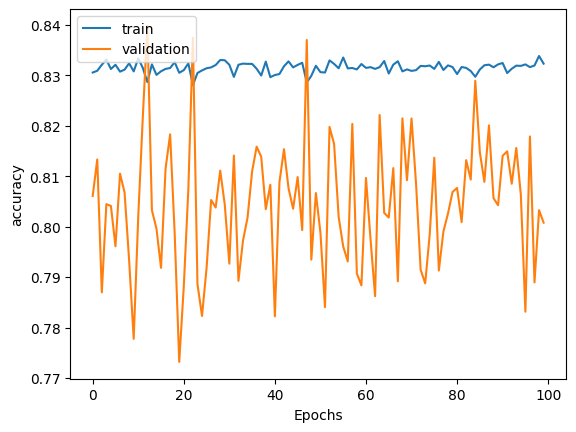


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.80      0.89    192558
         1.0       0.05      0.87      0.10      2516

    accuracy                           0.80    195074
   macro avg       0.53      0.83      0.49    195074
weighted avg       0.99      0.80      0.88    195074



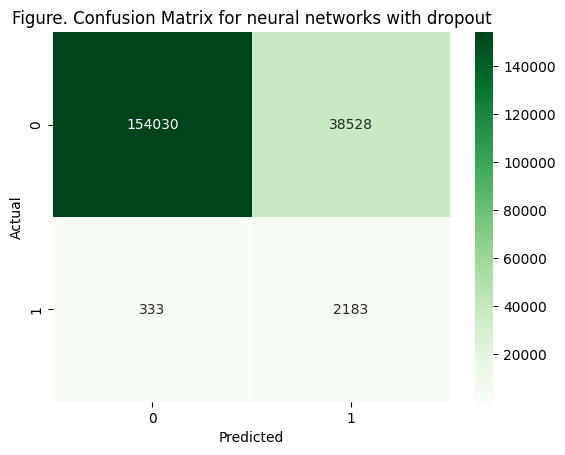

In [40]:
##### use droppout to prevent overfitting
number_of_input_features = 16 # Number of input features in the dataset

# Reduced number of hidden units to 5 and just using 1 hidden layer
number_of_hidden_units = 5 # Number of hidden units in the neural network
epochs = 100 # Number of training epochs
learning_rate = 0.01 # Learning rate for the optimizer
batch_size = 32 # Number of samples in each training batch
dropout_probablity = 0.6 # Probability of dropping out a neuron in dropout layer

# Convert training and testing data to PyTorch tensors
X_train_tensor = t.Tensor(X_resampled).type(t.float32)
Y_train_tensor = t.Tensor(Y_resampled).type(t.float32)
X_test_tensor = t.Tensor(X_test).type(t.float32)
Y_test_tensor = t.Tensor(Y_test).type(t.float32)

# Create a training dataset and data loader
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the neural network model
model = Sequential(
    Linear(number_of_input_features, number_of_hidden_units), # Linear layer for matrix multiplication and bias addition
    Tanh(), # Add Tanh activation function
    Dropout(dropout_probablity), # Dropout layer to prevent overfitting
    Linear(number_of_hidden_units, 1), # Another linear layer
    Sigmoid() # Sigmoid activation for probability output
)

# Define the optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Define the loss function as Binary Cross-Entropy Loss
loss_fn = t.nn.BCELoss()

train_accuracy_list = [] # List to store training accuracy
validation_accuracy_list = [] # List to store validation accuracy

# Training loop
for epoch in range(epochs):
    if epoch % 500 == 0:
      learning_rate *= 0.9 # Learning rate scheduling

    per_epoch_loss_list = [] # List to store losses for each epoch

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model(X)

        # Calculate the loss
        loss = loss_fn(probs.view(-1), Y)
        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradients and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model on training and validation data
    with t.no_grad():
        # Set the model in eval mode; some layers use this for certain calculations during training
        model.eval()

        # Calculate accuracy on train data
        probs = model(X_train_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_tensor).type(t.float32).mean().item()

        # Calculate accuracy on validation data
        probs = model(X_test_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()

        print(f'epoch {epoch}/{epochs} ---> train_accuracy: {train_accuracy}, validation_accuracy: {validation_accuracy}')

        # Set the model back to train mode
        model.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)


# Plot training and validation accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.show()

# confusion matrix
conf_matrix = confusion_matrix(Y_test_tensor, prediction)
class_report = classification_report(Y_test_tensor, prediction)

print("\nClassification Report:")
print(class_report)

sns.heatmap(conf_matrix, cmap='Greens', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Figure. Confusion Matrix for neural networks with dropout')
plt.show()



# prevent overfitting using early stop regularization

Streaming output truncated to the last 5000 lines.
epoch 26/30 ---> train_accuracy : 0.8389578461647034 , validation_accuracy : 0.8038436770439148
epoch 26/30 ---> train_accuracy : 0.8391066789627075 , validation_accuracy : 0.8030388355255127
epoch 26/30 ---> train_accuracy : 0.8392307758331299 , validation_accuracy : 0.8022699356079102
epoch 26/30 ---> train_accuracy : 0.8392555713653564 , validation_accuracy : 0.8014702200889587
epoch 26/30 ---> train_accuracy : 0.8392804265022278 , validation_accuracy : 0.8001630306243896
epoch 26/30 ---> train_accuracy : 0.8391315340995789 , validation_accuracy : 0.7992505431175232
epoch 26/30 ---> train_accuracy : 0.8388585448265076 , validation_accuracy : 0.7982970476150513
epoch 26/30 ---> train_accuracy : 0.8388089537620544 , validation_accuracy : 0.7980202436447144
epoch 26/30 ---> train_accuracy : 0.83873450756073 , validation_accuracy : 0.7978715896606445
epoch 26/30 ---> train_accuracy : 0.8387593030929565 , validation_accuracy : 0.79822528

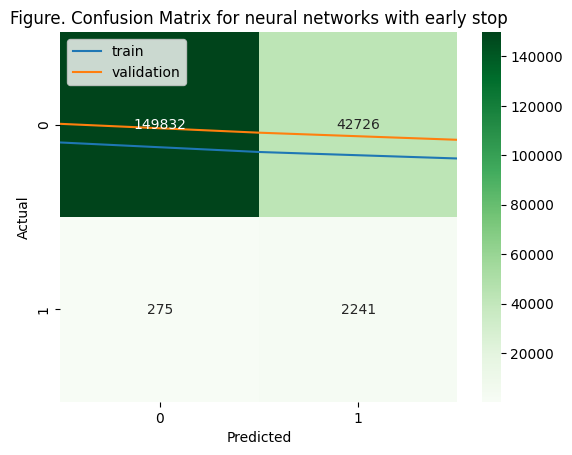

In [41]:
################################################## early stop regularization technique
# Importing necessary libraries
import torch as t
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import Sequential, Linear, Tanh, Sigmoid
from torch.optim import Adam
from torch.nn import BCELoss
import matplotlib.pyplot as plt


# Defining the parameters
number_of_input_features = 16
number_of_hidden_units = 5
epochs = 30
learning_rate = 0.01
batch_size = 32

# Loading and preprocessing the data
X_train_tensor = t.Tensor(X_resampled).type(t.float32)
Y_train_tensor = t.Tensor(Y_resampled).type(t.float32)

X_test_tensor = t.Tensor(X_test).type(t.float32)
Y_test_tensor = t.Tensor(Y_test).type(t.float32)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Creating a neural network model
model = Sequential(
    Linear(number_of_input_features, number_of_hidden_units),
    Tanh(),
    Linear(number_of_hidden_units, 1),
    Sigmoid()
)

# Setting up the optimizer and loss function
optimizer = Adam(model.parameters(), lr=learning_rate)
loss_fn = BCELoss()

# Lists to store accuracy values during training
train_accuracy_list = []
validation_accuracy_list = []

# Main training loop
for epoch in range(epochs):
    # Learning rate scheduling (optional)
    if epoch % 500 == 0:
        learning_rate *= .9

    per_epoch_loss_list = []

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        probs = model(X)

        # new loss is the old loss + regularization term
        loss = loss_fn(probs.view(-1), Y)

        per_epoch_loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        with t.no_grad():
            # Calculate accuracy on train data
            model.eval()
            probs = model(X_train_tensor)
            prediction = (probs >= .5).type(t.LongTensor).view(-1)

            train_accuracy = (prediction == Y_train_tensor).type(t.float32).mean().item()

            # Calculate accuracy on validation data
            probs = model(X_test_tensor)
            prediction = (probs > .5).type(t.LongTensor).view(-1)

            validation_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()

            print(f'epoch {epoch}/{epochs} ---> train_accuracy : {train_accuracy} , validation_accuracy : {validation_accuracy}')
            model.train()

            train_accuracy_list.append(train_accuracy)
            validation_accuracy_list.append(validation_accuracy)


# Plotting the training and validation accuracy
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label='validation')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


# confusion matrix
conf_matrix = confusion_matrix(Y_test_tensor, prediction)
class_report = classification_report(Y_test_tensor, prediction)

print("\nClassification Report:")
print(class_report)

sns.heatmap(conf_matrix, cmap='Greens', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Figure. Confusion Matrix for neural networks with early stop')
plt.show()



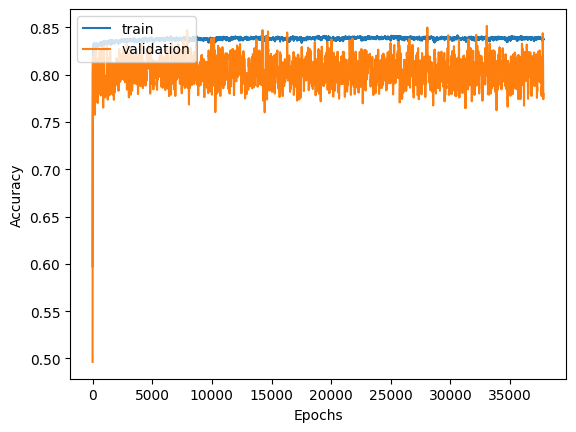


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.78      0.87    192558
         1.0       0.05      0.89      0.09      2516

    accuracy                           0.78    195074
   macro avg       0.52      0.83      0.48    195074
weighted avg       0.99      0.78      0.86    195074



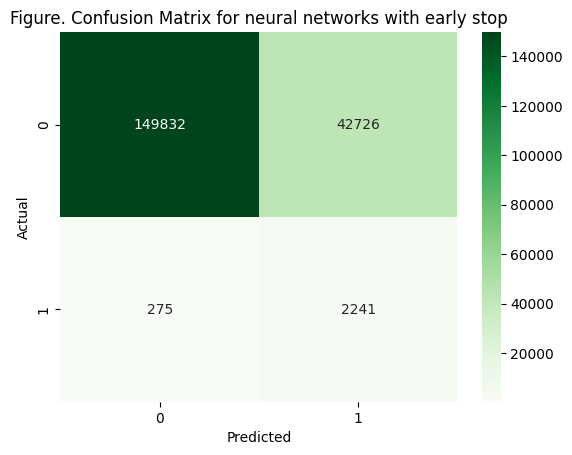

In [42]:
# Plotting the training and validation accuracy
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label='validation')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


# confusion matrix
conf_matrix = confusion_matrix(Y_test_tensor, prediction)
class_report = classification_report(Y_test_tensor, prediction)

print("\nClassification Report:")
print(class_report)

sns.heatmap(conf_matrix, cmap='Greens', annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Figure. Confusion Matrix for neural networks with early stop')
plt.show()